<a href="https://colab.research.google.com/github/mmmylj/colab_DL/blob/master/%E2%80%9CTF_CNN_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

KeyboardInterrupt: ignored

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import tensorflow as tf
import pylab
import os
import numpy as np

In [0]:
import pickle

def load_file(filename):
    with open(filename, 'rb') as fo:
        data = pickle.load(fo, encoding='latin1')
    return data

In [0]:
def GetPhoto(pixel):
    assert len(pixel) == 3072
    # 对list进行切片操作，然后reshape
    r = pixel[0:1024]; r = np.reshape(r, [32, 32, 1])
    g = pixel[1024:2048]; g = np.reshape(g, [32, 32, 1])
    b = pixel[2048:3072]; b = np.reshape(b, [32, 32, 1])

    photo = np.concatenate([r, g, b], -1)

    return photo

随机处理图片方法

In [0]:
#随机裁剪     
#     distorted_image = tf.random_crop(reshaped_image, [height, width, 3])

#随机水平翻转     
#     distorted_image = tf.image.random_flip_left_right(distorted_image)

#随机图片亮度
#     distorted_image = tf.image.random_brightness(distorted_image,
#随机图片对比度                                                  max_delta=63)
#     distorted_image = tf.image.random_contrast(distorted_image,
#                                                lower=0.2, upper=1.8)

#减去均值，除以方差，图片标准化
#     float_image = tf.image.per_image_standardization(distorted_image)

8


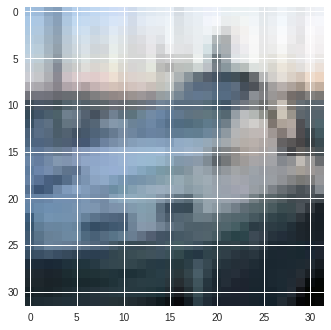

In [0]:
data = load_file('drive/cifar_10_database/test_batch')
photo = GetPhoto(data['data'][2])
print (data['labels'][2])
pylab.imshow(photo)
pylab.show()

In [0]:
data_dir = ['drive/cifar_10_database/test_batch_i' for i in range(4)]
# print (data_dir)

#duilde filename equaue
filename_equaue = tf.train.string_input_producer(data_dir)
reader_lenth = 32*32*3 + 1
reader = tf.FixedLengthRecordReader(reader_lenth)
key , vale = reader.read(filename_equaue)